# Learning progress: Resultados de Evaluación del BERT a lo largo del finetuning
# Profiling para 2ª iteración
## Datos:
* Muestra fenotipos/etiquetas: [index-31-05-clean-train.csv](../../../data/phenotypes/index-31-05-clean-train.csv)
  * $M = 6107$ tags o fenotipos de entrenamiento. 
  * Todos los pares de tags fueron usados para la evaluación de training.
* Abstracts de los que se tomó la muestra: [abstracts-31-05-clean-train.csv](../../../data/abstracts/abstracts-31-05-clean-train.csv)
  * $N = 1532$ abstracts.
  * Obtenidos de una búsqueda en [pubmed](https://pubmed.ncbi.nlm.nih.gov/)
* Fenotipos test: [index-31-05-clean-test.csv](../../../data/phenotypes/index-31-05-clean-test.csv) = muestra de nodos hoja del subárbol depth<=10 de HPO:Phenotypic Abnormality.
  * Muestra de 8000 pares de fenotipos para la evaluación de test [test_pairs-31-05.csv](../../../data/evaluation/test_pairs-31-05.csv).
## Resumen del modelo:
Modelo original: [pritamdeka](https://huggingface.co/pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb).  
Modelo obtenido: [README.md](../../../output/fine-tuned-bio-bert-ev-nz_2-1-06-2024/README.md)  

## Resumen del entrenamiento
* batch_size = 16, longitud del dataloader = 383 = nº batches / epoch.
* epochs = 10
* evaluation steps = 38 (10 pasos de evaluación / epoch)
* warmup steps = 76
* Loss Function: BatchAllTripletLoss con distancia de coseno y margin=0.3743.
* Evaluation Function: SequentialEvaluator compuesto por:
  1. EmbeddingSimilarityEvaluator(main_similarity=SimilarityFunction.COSINE): para cada par de muestra obtiene la similitud coseno y calcula los scores de correlación de pearson y spearman respecto de las similitudes gold pasadas por parámetro (lin entre fenotipos). Devuelve el score de spearman.
    * Train: resultados en [similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-nz_2-22-05-2024/eval/similarity_evaluation_train_results.csv)
    * Test: [similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-nz_2-22-05-2024/eval/similarity_evaluation_test_results.csv)
  2. MSESimilarityEvaluator(main_similarity=SimilarityFunction.COSINE), implementado por mí: funciona igual que el anterior pero el score devuelto es el MSE entre las similitudes coseno y las gold.
    * Train: [MSE_similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-nz_2-22-05-2024/eval/MSE_similarity_evaluation_train_results.csv)
    * Test: [MSE_similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-nz_2-22-05-2024/eval/MSE_similarity_evaluation_test_results.csv)
* save_best_model = True : El modelo que se guardó fue el que tuvo mayor correlación de Spearman de Test.
* Resto de hiperparámetros por defecto: lr = 2E-5, weight_decay = 0.01, max_grad_norm = 1.
* Tiempo de entrenamiento: 1h (GPU)

## 1. Carga de datos

In [1]:
# Import global variables from project_config.py

import os
import sys
from IPython.core.getipython import get_ipython

# Absolute path of the current notebook
notebook_path = os.path.realpath(os.path.join(os.getcwd(), get_ipython().starting_dir))
# Add module to system path
config_path = os.path.join(os.path.dirname(os.path.dirname(notebook_path)), "project_config")
sys.path.append(config_path)

import project_config
from project_config import *

print(f"SEED={SEED}")

SEED=42


In [2]:
# IMPORTS

from cmath import nan
import sentence_transformers
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

from pyhpo import Ontology

from sentence_transformers.evaluation import SimilarityFunction
import MSESimilarityEvaluator as MSESim
from MSESimilarityEvaluator import MSESimilarityEvaluator
import time

from matplotlib import pyplot as plt

torch.manual_seed(SEED)
print(torch.cuda.is_available())

True


In [3]:
# 0. GPU
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.cuda.empty_cache() 

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"

Device: cuda:0


In [4]:
# 1. Cargar todos los datos (crudos)

# 1.1 BERT de partida

MAX_SEQ_LENGTH = 256
bertmodel = SentenceTransformer(PRITAMDEKAMODEL, device=device) # Original
model = bertmodel # Para finetunear

# 1.2 Ontología

onto = Ontology(PATH_ONTO)

/home/dmg/.conda/envs/bert_3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# 1.3 Datos de entrenamiento y evaluación (csv)

# abstracts (train)
path_abstracts_train = os.path.join(PATH_ABSTRACTS, 'abstracts-31-05-train.csv')
dTrain = pd.read_csv(path_abstracts_train, sep='\t', low_memory=False, na_values=['', nan])

PROFILING = True
if PROFILING:
    dTrain = dTrain.sample(frac=0.01, random_state=SEED, ignore_index=True)

print(f"N={dTrain.shape[0]} abstracts")

N=8027 abstracts


In [6]:
# fenotipos hoja
path_phenotypes = os.path.join(PATH_PHENOTYPES, 'phenotypes_nz_05-05_10.csv')
dfPhenotypes = pd.read_csv(path_phenotypes, sep='\t', low_memory=False, na_values=['', nan])


# fenotipos tags
path_index = os.path.join(PATH_PHENOTYPES, 'index-31-05-train.csv')
dfIndex = pd.read_csv(path_index, sep='\t', low_memory=False, na_values=['', nan])
print(f"m={dfIndex.shape[0]} tags")

m=4070 tags


In [7]:
# pares fenotipos train
path_pairs_train = os.path.join(PATH_EVALUATION, 'train_pairs-31-05.csv')
dfVal = pd.read_csv(path_pairs_train, sep='\t', low_memory=False, na_values=['', nan])

# test
path_pairs_test = os.path.join(PATH_EVALUATION, 'test_pairs-31-05.csv')
dfTest = pd.read_csv(path_pairs_test, sep='\t', low_memory=False, na_values=['', nan])

if PROFILING:
    dfVal = dfVal.sample(frac=0.2, random_state=SEED, ignore_index=True)
    dfTest = dfTest.sample(frac=0.2,random_state=SEED, ignore_index=True)

print(dfVal.info())
print(dfTest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phenotype1  1000 non-null   object 
 1   phenotype2  1000 non-null   object 
 2   lin         1000 non-null   float64
dtypes: float64(1), object(2)
memory usage: 23.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   phenotype1  1000 non-null   object 
 1   phenotype2  1000 non-null   object 
 2   lin         1000 non-null   float64
dtypes: float64(1), object(2)
memory usage: 23.6+ KB
None


## 2. Preparación del entrenamiento
Vamos a construir los dataloaders y las funciones de pérdida y evaluación.

### Dataloaders

In [8]:
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, SentencesDataset, losses, evaluation, InputExample

# 2.1. Ejemplos de entrenamiento
tags = dfIndex['phenotypeName']
numlabels = len(tags)
mapping = {tag: i for i, tag in enumerate(tags)}

def getLabelNumber(phenotypeName):
    return mapping[phenotypeName]

BATCH_SIZE = 16
abstractsTrain = [InputExample(texts=[x], label=mapping[y]) for x, y in zip(dTrain['clean_abstract'], dTrain['phenotypeName'])]
train_dataloader = DataLoader(abstractsTrain, shuffle=True, batch_size=BATCH_SIZE)
print("batch_size=", BATCH_SIZE)

# 2.2. Ejemplos de validación

ltrain1 = dfVal['phenotype1']
ltrain2 = dfVal['phenotype2']
goldTrain = dfVal['lin']

# 2.3. Ejemplos de test

ltest1 = dfTest['phenotype1']
ltest2 = dfTest['phenotype2']
goldTest = dfTest['lin']

batch_size= 16


### Hiperparámetros
[hiperparams.csv](./hiperparams.csv)

In [9]:
dfhiper = pd.read_csv('hiperparams-4.csv', sep=';', low_memory=False, na_values=['', nan])

q = 0.99
MARGIN = 1-goldTrain.quantile(q)
NUM_EPOCHS = int(dfhiper['num_epochs'].iloc[0]) if 'num_epochs' in dfhiper else 5
STEPS = int(dfhiper['ev_steps'].iloc[0]) if 'ev_steps' in dfhiper else 5
WARMUP_STEPS_FRAC = int(dfhiper['warmup_steps'].iloc[0]) if 'warmup_steps' in dfhiper else 5
BERTNAME = 'fine-tuned-bio-bert-ev-7'
output_path = os.path.join(PATH_OUTPUT, BERTNAME + '-' + pd.Timestamp("today").strftime("%d-%m-%Y"))
num_batches = len(train_dataloader)
lr = float(dfhiper['lr'].iloc[0]) if 'lr' in dfhiper else 5e-6
wd = 0
print(f'Hiperparams: N={num_batches}, lr={lr}, wd={wd} NUM_EPOCHS={NUM_EPOCHS}, STEPS={STEPS}, WARMUP_STEPS_FRAC={WARMUP_STEPS_FRAC}, MARGIN={MARGIN}, BERTNAME={BERTNAME}')

num_epochs = 10
ev_steps = num_batches // STEPS
warmup_steps = num_batches // WARMUP_STEPS_FRAC

model.max_seq_length = MAX_SEQ_LENGTH
print("max_seq_length = ", model.get_max_seq_length())

Hiperparams: N=502, lr=5e-06, wd=0 NUM_EPOCHS=10, STEPS=10, WARMUP_STEPS_FRAC=5, MARGIN=0.6808065865552051, BERTNAME=fine-tuned-bio-bert-ev-7
max_seq_length =  256


### Funciones de pérdida y evaluación
El código de MSESimilarityEvaluator puede verse en [MSESimilarityEvaluator.py](./MSESimilarityEvaluator.py)

In [10]:
# 2.4 Loss

train_loss = losses.BatchHardSoftMarginTripletLoss(model=model, distance_metric=losses.BatchHardTripletLossDistanceFunction.cosine_distance)

# 2.5 Evaluation

evaluatorTrain1=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltrain1, ltrain2, goldTrain,
                                                                             main_similarity=SimilarityFunction.COSINE,
                                                                             name='train')
evaluatorTrain2=MSESimilarityEvaluator(ltrain1, ltrain2, goldTrain, main_similarity=SimilarityFunction.COSINE,name='train')
evaluatorTest1=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltest1, ltest2, goldTest,
                                                                            main_similarity=SimilarityFunction.COSINE,
                                                                            name='test')
evaluatorTest2=MSESimilarityEvaluator(ltest1, ltest2, goldTest, main_similarity=SimilarityFunction.COSINE,name='test')
combined_evaluator = evaluation.SequentialEvaluator([evaluatorTrain1, evaluatorTrain2, evaluatorTest1, evaluatorTest2],
                                                    main_score_function=lambda scores: scores[2])

In [11]:
scoreTrain = evaluatorTrain1.__call__(model=bertmodel, output_path='./results/original', epoch=0, steps=0)
scoreTest = evaluatorTest1.__call__(model=bertmodel, output_path='./results/original', epoch=0, steps=0)
print(f'Original score (spearman): {scoreTrain} (train), {scoreTest} (test)')

Original score (spearman): 0.05488633165528009 (train), 0.0793751166523376 (test)


## 3. Fit

In [12]:
print("Fitting...")
import time
FITTED = False
if FITTED:
    DATE = "1-06-2024"
    output_path = os.path.join(PATH_OUTPUT, BERTNAME+'-'+DATE)
    model = SentenceTransformer(output_path)
    with open(os.path.join(PATH_OUTPUT, BERTNAME+'-'+DATE, 'eval', 'time.txt'), 'r') as f:
        s = f.read()
        execution_time = float(s.split()[0])
else:
    start_time = time.time()
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=combined_evaluator,
        epochs=num_epochs,
        optimizer_params = {'lr':lr},
        evaluation_steps=ev_steps,
        warmup_steps=warmup_steps,
        output_path=output_path,
        save_best_model=SAVE_BEST,
        checkpoint_path='./checkpoint',
        checkpoint_save_steps=ev_steps,
        checkpoint_save_total_limit=num_epochs
    )

    end_time = time.time()
    execution_time = end_time - start_time

print(f"Execution time for model.fit: {execution_time:.2f} seconds")
fmodel = model # finetuned model

Fitting...


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Iteration:   0%|          | 0/502 [00:00<?, ?it/s]

Execution time for model.fit: 2846.74 seconds


## 4. Evaluación
Durante el entrenamiento se van guardando los resultados de evaluación en cada evaluation step en:
* Correlaciones Train: [similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/similarity_evaluation_train_results.csv)
* Correlaciones Test: [similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/similarity_evaluation_test_results.csv)
* MSE Train: [MSE_similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/MSE_similarity_evaluation_train_results.csv)
* MSE Test: [MSE_similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/MSE_similarity_evaluation_test_results.csv)

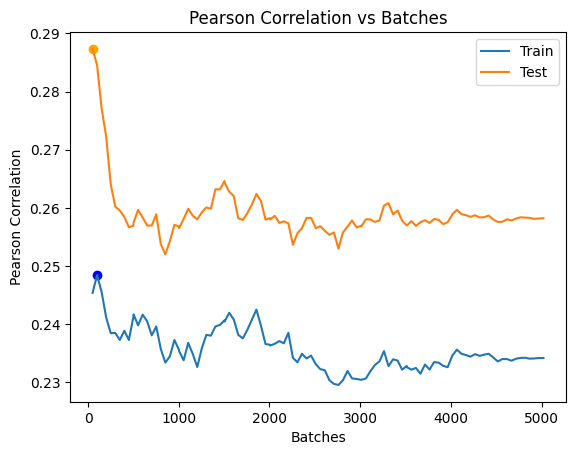

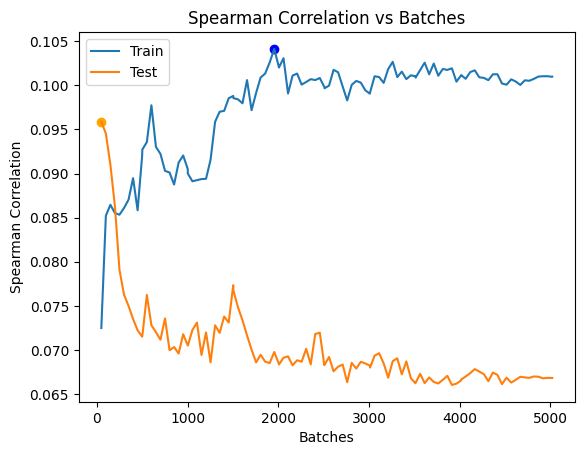

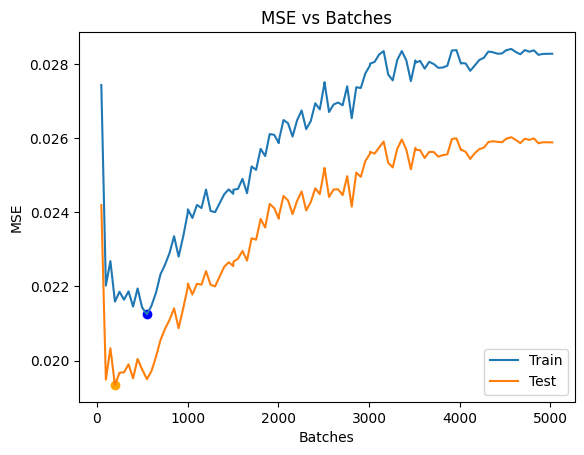

Train best scores:
             metric     value    step
0   cosine_pearson  0.248442   100.0
1  cosine_spearman  0.104131  1956.0
2       MSE_cosine  0.021249   552.0
Test best scores:
             metric     value   step
0   cosine_pearson  0.287324   50.0
1  cosine_spearman  0.095886   50.0
2       MSE_cosine  0.019347  200.0


In [13]:
from plot_lprogress import plot_eval

path_eval = os.path.join(output_path, 'eval')

dfScoreTrain, dfScoreTest = plot_eval(path_eval, num_batches, save=False)
print('Train best scores:\n', dfScoreTrain)
print('Test best scores:\n', dfScoreTest)

* **Statements**: Parece que la prueba para profiling funciona bien.


## 5. Estudio estadístico de los datos

Esto se debería haber hecho antes del fine-tuning. Vamos a estudiar la distribución de algunas características de los datos de entrada, especialmente de los fenotipos para tag / evaluación.

### 5.1 Similitudes gold entre pares de fenotipos

Lin train distribution:
count    1000.000000
mean        0.022021
std         0.069234
min         0.000000
25%         0.000045
50%         0.000050
75%         0.000065
max         0.760147
Name: lin, dtype: float64
Lin test distribution:
count    1000.000000
mean        0.023336
std         0.071136
min         0.000000
25%         0.000044
50%         0.000048
75%         0.000080
max         0.576560
Name: lin, dtype: float64


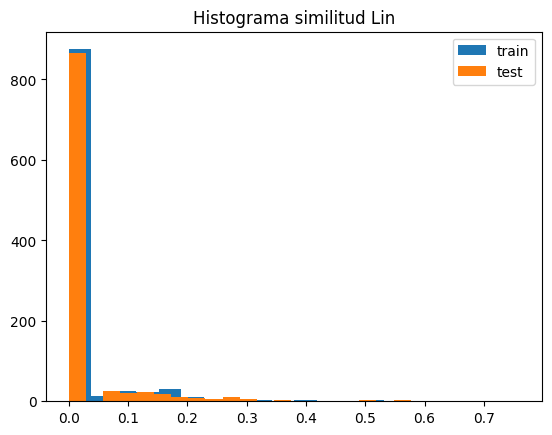

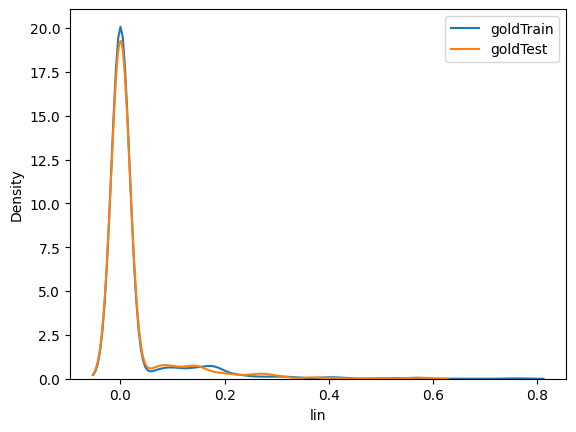

In [22]:
# Dibujar la distribución de gold train

print("Lin train distribution:")
print(goldTrain.describe())
# Dibujar la distribución de gold test

print("Lin test distribution:")
print(goldTest.describe())

plt.hist(goldTrain, bins=20, label='train')
plt.hist(goldTest, bins=20, label='test')
plt.legend()
plt.title('Histograma similitud Lin')
plt.show()

import seaborn as sns

sns.kdeplot(goldTrain, label='goldTrain')
sns.kdeplot(goldTest, label='goldTest')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [23]:
# Test de normalidad de gold

from scipy.stats import shapiro
for gold in [goldTrain, goldTest]:
    stat, p = shapiro(gold)
    print(f'Statistics={stat}, p={p}')
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')


Statistics=0.36402254061204253, p=3.792725317997126e-50
Sample does not look Gaussian (reject H0)
Statistics=0.3779116708929362, p=8.558765826459352e-50
Sample does not look Gaussian (reject H0)


### 5.2 Abstracts

count    8027.000000
mean      138.442133
std        54.817235
min        25.000000
25%       100.000000
50%       140.000000
75%       171.000000
max       484.000000
Name: wordcount, dtype: float64
Max seq length: 256


484

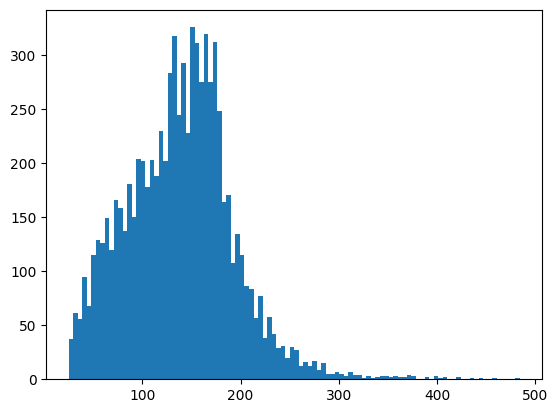

In [24]:
dTrain['wordcount']=dTrain['clean_abstract'].apply(lambda x: len(x.split()))
plt.hist(dTrain['wordcount'], bins=100)
print(dTrain['wordcount'].describe())
print(f'Max seq length: {fmodel.get_max_seq_length()}')

# Should have set it before training
fmodel.max_seq_length = max(dTrain['wordcount'])
fmodel.get_max_seq_length()

### 5.3 IC de los Fenotipos

count    6107.000000
mean        7.021452
std         1.355080
min         1.816136
25%         6.099095
50%         7.398378
75%         8.496990
max         8.496990
Name: ic, dtype: float64


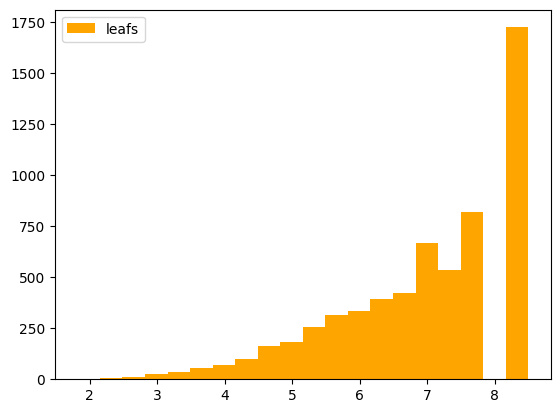

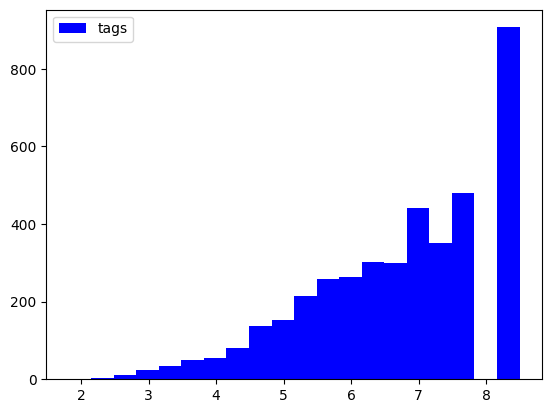

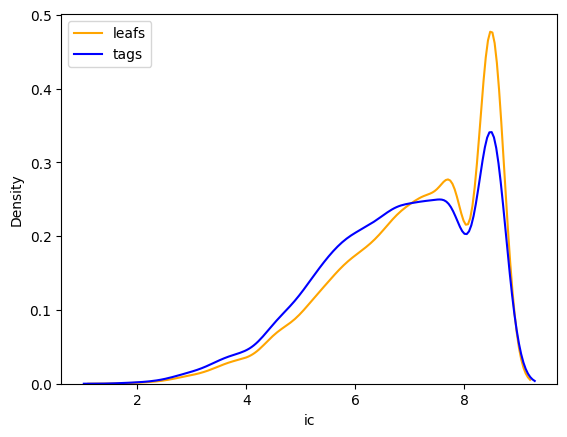

In [25]:
def get_ic(phenName):
    phen = onto.get_hpo_object(phenName)
    return phen.information_content.gene

dfPhenotypes['ic'] = dfPhenotypes['id'].apply(get_ic)
dfIndex['ic'] = dfIndex['phenotypeName'].apply(get_ic)

print(dfPhenotypes['ic'].describe())
plt.hist(dfPhenotypes['ic'], bins=20, label='leafs', color='orange')
plt.legend()
plt.show()

plt.hist(dfIndex['ic'], bins=20, label='tags', color='blue')
plt.legend()
plt.show()

sns.kdeplot(dfPhenotypes['ic'], label='leafs', color='orange')
sns.kdeplot(dfIndex['ic'], label='tags', color='blue')
plt.legend()
plt.show()